## Dedicated to various Lidar differencing

Pixel offset tracking:
- DEM
- Hillshade
- Slope map 

Windowed ICP:

In [2]:
import json
import matplotlib.pyplot as plt
import pdal

(PDAL Error) Can't load library /Users/chanagan/miniconda3/envs/icp/lib/libpdal_plugin_filter_trajectory.dylib: Failed to load "/Users/chanagan/miniconda3/envs/icp/lib/libpdal_plugin_filter_trajectory.dylib": dlopen(/Users/chanagan/miniconda3/envs/icp/lib/libpdal_plugin_filter_trajectory.dylib, 0x0002): Library not loaded: @rpath/libblas.3.dylib
  Referenced from: <E912F932-8570-3B8F-B09E-96DF1C77AB89> /Users/chanagan/miniconda3/envs/icp/lib/libcholmod.3.0.14.dylib
  Reason: tried: '/Users/chanagan/miniconda3/envs/icp/lib/libblas.3.dylib' (no such file), '/Users/chanagan/miniconda3/envs/icp/lib/libblas.3.dylib' (no such file), '/Users/chanagan/miniconda3/envs/icp/lib/libblas.3.dylib' (no such file), '/Users/chanagan/miniconda3/envs/icp/lib/libblas.3.dylib' (no such file), '/Users/chanagan/miniconda3/envs/icp/lib/libblas.3.dylib' (no such file), '/Users/chanagan/miniconda3/envs/icp/bin/../lib/libblas.3.dylib' (no such file), '/usr/local/lib/libblas.3.dylib' (no such file), '/usr/lib/lib

In [1]:
im1 = '/Users/chanagan/Desktop/micmac/LidarTests/2007.laz'
im2 = '/Users/chanagan/Desktop/micmac/LidarTests/2018.laz'

a_ullr = [700672.4,4007759.8,702333.6,4006198.6]



 

In [80]:
# ICP window and step sizes
window_size = 50
step_size = 25
extra = 10

Displacement vector at X=700697.0, Y=4006223.0: dx=13.2615141304886, dy=-2.06613781441
Displacement vector at X=700697.0, Y=4006248.0: dx=12.7522850699976, dy=4.4347748516353
Displacement vector at X=700697.0, Y=4006273.0: dx=11.4256156762834, dy=4.40317489272774
Displacement vector at X=700697.0, Y=4006298.0: dx=9.55818434644609, dy=-0.136614624427475
Displacement vector at X=700697.0, Y=4006323.0: dx=9.72466505825346, dy=-2.29473174850166
Displacement vector at X=700697.0, Y=4006348.0: dx=11.1693907800728, dy=-3.06771385628994
Displacement vector at X=700697.0, Y=4006373.0: dx=11.6016994530732, dy=2.15334148226792
Displacement vector at X=700697.0, Y=4006398.0: dx=10.8418599155727, dy=4.33050872724922
Displacement vector at X=700697.0, Y=4006423.0: dx=10.3527457682622, dy=3.63972422416134
Displacement vector at X=700697.0, Y=4006448.0: dx=9.65194744800236, dy=3.54981578751309
Displacement vector at X=700697.0, Y=4006473.0: dx=8.34757374907471, dy=1.58387652129506
Displacement vector 

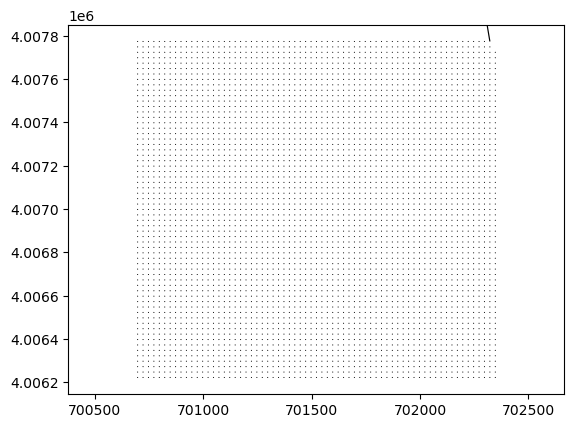

In [31]:
# ICP window and step sizes
window_size = 50
step_size = 25
extra = 10

# Path to pre- and post-event indexed point clouds (EPT)
pre_event_index = im1
post_event_index = im2

# Variables to hold the ICP vector origins (X, Y) and displacements (dx, dy)
X = []
Y = []
dx = []
dy = []

# Slide a window through the analysis area
for x in range(int(a_ullr[0]), int(a_ullr[2]), step_size):
    for y in range(int(a_ullr[3]), int(a_ullr[1]), step_size):

        # PDAL pipeline with data bounds set according to the current window.
        # The first window is 'fixed'; The second window is 'moving'.
        # Note that we pad the 'fixed' window so the second window has room to
        # move within the fixed window as the ICP solution converges.
        pipeline1 = [
            {
                'type':'readers.las',
                'filename':post_event_index
            },
            {
                'type':'filters.crop',
                'bounds':'([{},{}],[{},{}])'.format(x - extra,
                                                    x + window_size + extra,
                                                    y - extra,
                                                    y + window_size + extra)
            },
            {'type':'writers.las',
             'filename':'tmp1.las'}
        ]
        # Execute the pipeline
        p1 = pdal.Pipeline(json.dumps(pipeline1))
        p1.execute()
        pipeline2 = [{
                'type':'readers.las',
                'filename':pre_event_index
            },
            {
                'type':'filters.crop',
                'bounds':'([{},{}],[{},{}])'.format(x,
                                                    x + window_size,
                                                    y,
                                                    y + window_size)
            },
            {'type':'writers.las',
             'filename':'tmp2.las'}
        ]
        # Execute the pipeline
        p2 = pdal.Pipeline(json.dumps(pipeline2))
        p2.execute()
        pipeline3 = ['tmp1.las',
            'tmp2.las',
            {
                'type':'filters.icp'
            }
        ]
        # Execute the pipeline
        p = pdal.Pipeline(json.dumps(pipeline3))
        p.execute()

        # Capture the metadata, which contains the ICP transformation
        m = p.metadata
        t = m.get('metadata').get('filters.icp').get('transform')

        # Store vector origin and ICP-derived displacement
        try:
            t = [float(val) for val in t.split()]
            X.append(x + window_size/2)
            Y.append(y + window_size/2)
            dx.append(t[3])
            dy.append(t[7])
        except:
            pass

        # Print status
        print('Displacement vector at X={}, Y={}: dx={}, dy={}'.format(
            X[-1], Y[-1], dx[-1], dy[-1]))

# Plot the ICP vectors
plt.figure()
plt.quiver(X, Y, dx, dy, angles='xy', scale_units='xy')
plt.axis('equal')
plt.show()

# Results

In [4]:
import numpy as np
import pandas as pd

In [9]:
#df = pd.DataFrame({'X':X,'Y':Y,'dx':dx,'dy':dy})
#df.to_csv('LidarDiffResults.txt',sep='\t',index=False)
df = pd.read_csv('LidarDiffResults.txt',sep='\s+')


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_67697/3880482281.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('LidarDiffResults.txt',sep='\s+')


In [60]:
# Filter out implausible displacements based on window size
id = df[(df['dx'] >= 50) | (df['dx'] <= -50) | (df['dy'] >= 50) | (df['dy'] <= -50)].projected_displacement.index

In [62]:
fdf = df#df[(df['dx'] <= 50) & (df['dx'] >= -50) & (df['dy'] <= 50) & (df['dy'] >= -50)]

In [63]:
# Assuming you have already created the dataframe df
azimuth = 315  # Azimuth angle in degrees
theta = np.radians(azimuth)  # Convert azimuth angle to radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

# Rotate displacements by 45 degrees clockwise
displacements_rotated = np.dot(rotation_matrix, np.array([fdf['dx'].values, fdf['dy'].values]))

# Project displacements onto x-axis (parallel to the azimuth)
projected_displacements = displacements_rotated[0]

# Add the projected displacements to the dataframe
fdf['projected_displacement'] = projected_displacements
fdf.loc[id,['dx','dy','projected_displacement']] = -9999

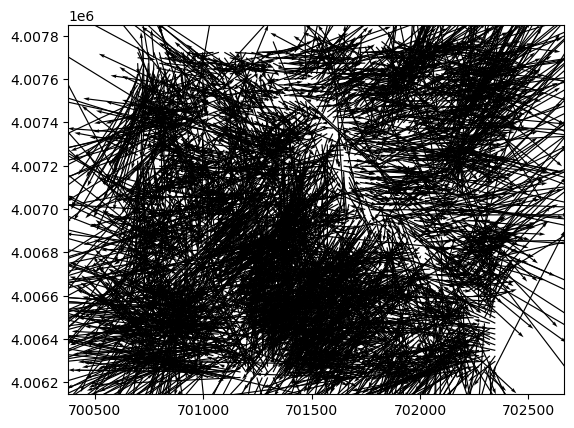

In [120]:
# Plot the ICP vectors
plt.figure()
plt.quiver(fdf.X, fdf.Y, fdf.dx, fdf.dy, angles='xy', scale_units='xy',scale=0.01)
plt.axis('equal')
plt.show()

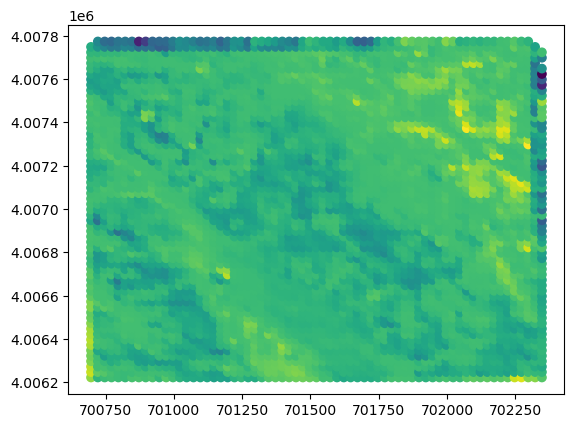

In [89]:
plt.scatter(fdf[fdf.projected_displacement!=-9999].X,fdf[fdf.projected_displacement!=-9999].Y,c=fdf[fdf.projected_displacement!=-9999].projected_displacement)

In [65]:
import sys
sys.path.append('../Functions')
import TiffTools as tt

from osgeo import gdal

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
# create dem
pipeline1 = [
        im1,
        {
            "filename":"/Users/chanagan/Desktop/micmac/LidarTests/2007.tif",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"0.5",
            "type": "writers.gdal"
        }
    ]
# create dem
pipeline2 = [
        im2,
        {
            "filename":"/Users/chanagan/Desktop/micmac/LidarTests/2018.tif",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"0.5",
            "type": "writers.gdal"
        }
    ]

In [137]:
p = pdal.Pipeline(json.dumps(pipeline1))
p.execute()

14534269

In [14]:
im = gdal.Open('/Users/chanagan/Desktop/micmac/LidarTests/2018.tif')

/Users/chanagan/miniconda3/envs/icp/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [15]:
band = im.GetRasterBand(1).ReadAsArray()

In [108]:
arr = np.zeros([len(fdf.Y.unique()), len(fdf.X.unique())])

In [118]:
for i,y in enumerate(fdf.Y.unique()):
    for j,x in enumerate(fdf.X.unique()):
        arr[len(fdf.Y.unique()) - i -1,j] = fdf[(fdf.X == x) & (fdf.Y == y)].projected_displacement.values[0]

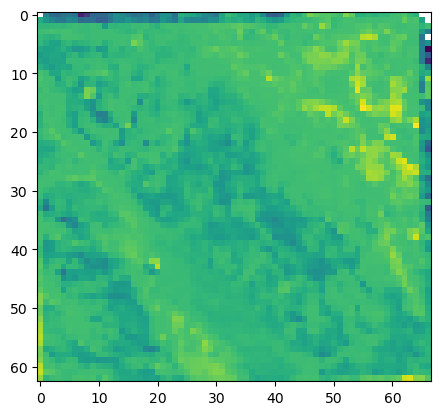

In [119]:
tmp = arr
tmp[tmp == -9999] = np.nan
plt.imshow(arr)

In [120]:
gt = (im.GetGeoTransform()[0],step_size,0.0,im.GetGeoTransform()[3],0.0,-step_size)

In [121]:
#tt.save_geotiff(arr, '/Users/chanagan/Desktop/micmac/LidarTests/projected_displacement.tif', geotransform=gt, projection=im.GetProjection(),nodata=-9999)

## DEM pixel offset tracking

In [144]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [151]:
# Projected displacements
azimuth = 315
folder = '/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/MEC/'

tt.micmacPostProcessing(folder=folder,
                         prefile='/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/2009dem.tif',
                        outprefix=folder)

cor = gdal.Open(folder+'Correlmicmac.tif')
mask = (cor.GetRasterBand(1).ReadAsArray() > 0.5)
ewtif = folder+'EWmicmac.tif'
nstif = folder+'NSmicmac.tif'
print('Working in',folder)
par, perp = tt.projectDisp(ewtif,nstif,azimuth,mask=mask,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')

Saving /Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/MEC/NSmicmac.tif
Saving /Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/MEC/EWmicmac.tif
Saving /Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/MEC/Correlmicmac.tif
Working in /Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/MEC/


In [127]:
# create a hillshade
#!gdaldem hillshade /Users/chanagan/Desktop/micmac/LidarTests/2018.tif /Users/chanagan/Desktop/micmac/LidarTests/2018hillshade.tif -of GTiff -b 1 -z 1.0 -s 1.0 -az 315.0 -alt 45.0
#!gdaldem hillshade /Users/chanagan/Desktop/micmac/LidarTests/2007.tif /Users/chanagan/Desktop/micmac/LidarTests/2007hillshade.tif -of GTiff -b 1 -z 1.0 -s 1.0 -az 315.0 -alt 45.0
# Rotate raster


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [152]:
im = gdal.Open('/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/orthos/09AUG04WVortho.tif')
band = im.GetRasterBand(1).ReadAsArray()

In [161]:
ogt = im.GetGeoTransform()
gt = (ogt[0],ogt[1],np.pi/2,ogt[3],np.pi/2,ogt[5])
gt

(694267.9702548566,
 0.5,
 1.5707963267948966,
 4017251.22044635,
 1.5707963267948966,
 -0.5)

In [160]:
tt.save_geotiff(band,'/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/orthos/09AUG04WVortho_rotated.tif', geotransform=gt, projection= im.GetProjection(),nodata=-9999)

In [162]:
9000+300*9

11700